# Prototyping 

In [2]:
import os
from zipfile import ZipFile
import torchvision
from PIL import Image
import torch
from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [22]:
os.mkdir(os.path.join(os.getcwd(), "dataset"))
if "cartoonset100k_jpg" not in os.listdir():
    zip_dir = os.getcwd() + "/dataset/" + "downloaded_data.zip"
    with ZipFile(zip_dir, "r") as zipObject:
        zipObject.extractall("dataset")

In [5]:
os.getcwd()

'd:\\Projekty\\Emojify\\model'

In [25]:
transform = torchvision.transforms.Compose([
    # torchvision.transforms.Resize(128, interpolation=Image.BILINEAR),
    torchvision.transforms.CenterCrop(256),
    torchvision.transforms.Resize(128, interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder("D:/Projekty/Emojify/model/dataset/temp_ds", transform=transform)
train, val, test = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])

batch_size = 128
num_workers = 0

trainLoader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
valLoader = torch.utils.data.DataLoader(val, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
testLoader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)

In [26]:
print("Number of pictures: ", len(dataset))
print("Train batches: ", len(trainLoader))
print("Val batches: ", len(valLoader))
print("Test batches: ", len(testLoader))

Number of pictures:  10000
Train batches:  46
Val batches:  15
Test batches:  15


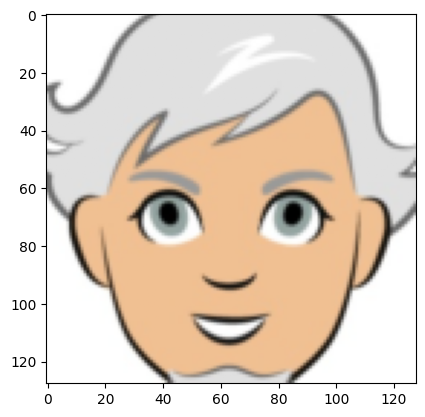

In [27]:
for images, _ in trainLoader:
    image = images[0]
    plt.imshow(image.permute(1,2,0))
    plt.show()
    break

In [28]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", DEVICE)

Device:  cuda


In [66]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args
    def forward(self, x):
        return x.view(self.shape)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, bias=False, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, bias=False, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, bias=False, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64*8*8, 200)
        self.fc_logvar = nn.Linear(64*8*8, 200)

        self.decoder = nn.Sequential(
            nn.Linear(200, 64*8*8),
            Reshape(-1, 64, 4, 4),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        std = std.to(DEVICE)
        eps = torch.randn(mu.size(0), mu.size(1))
        eps = eps.to(DEVICE)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        encoded = self.reparametrize(mu, logvar)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 3, 128, 128)
        return decoded, mu, logvar, encoded

In [67]:
model = VAE()
model = model.to(DEVICE)
input_size = (3, 128, 128)
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,536
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,768
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          65,536
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          65,536
              ReLU-8             [-1, 64, 8, 8]               0
           Flatten-9                 [-1, 4096]               0
           Linear-10                  [-1, 200]         819,400
           Linear-11                  [-1, 200]         819,400
           Linear-12                 [-1, 4096]         823,296
          Reshape-13             [-1, 64, 4, 4]               0
  ConvTranspose2d-14             [-1, 6

In [78]:
LEARNING_RATE = 0.005
NUM_EPOCHS = 50
beta = 0.01
model = VAE()
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

def vae_loss(recon_x, x, mu, logvar, beta):
    # print("Recon_x: ", recon_x.shape)
    # print("x: ", x.shape)
    # recon_loss = torch.nn.functional.cross_entropy(recon_x, x, reduction='none')
    recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='none')
    recon_loss = recon_loss.view(batch_size, -1).sum(axis=1)
    recon_loss = recon_loss.mean()

    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar), axis=1)
    kld_loss = kld_loss.mean()
    total_loss = recon_loss + beta * kld_loss

    return total_loss

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainLoader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, logvar, _ = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(trainLoader)

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_data, _ in valLoader:
            val_data = val_data.to(DEVICE)

            val_recon_batch, val_mu, val_logvar, _ = model(val_data)
            val_loss += vae_loss(val_recon_batch, val_data, val_mu, val_logvar, beta).item()

        val_loss /= len(valLoader)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: %.2f" % (train_loss), "Validation Loss: %.2f" % (val_loss))              

print("Finished")

Epoch 1/50, Loss: 5436.99 Validation Loss: 3984.78
Epoch 2/50, Loss: 3284.21 Validation Loss: 2579.69
Epoch 3/50, Loss: 2099.55 Validation Loss: 1688.21
Epoch 4/50, Loss: 1453.07 Validation Loss: 1258.06
Epoch 5/50, Loss: 1141.65 Validation Loss: 1068.38
Epoch 6/50, Loss: 985.92 Validation Loss: 935.24
Epoch 7/50, Loss: 876.75 Validation Loss: 845.32
Epoch 8/50, Loss: 812.79 Validation Loss: 783.10
Epoch 9/50, Loss: 735.85 Validation Loss: 728.06
Epoch 10/50, Loss: 685.81 Validation Loss: 767.76
Epoch 11/50, Loss: 644.42 Validation Loss: 623.32
Epoch 12/50, Loss: 600.54 Validation Loss: 595.88
Epoch 13/50, Loss: 571.62 Validation Loss: 588.23
Epoch 14/50, Loss: 540.14 Validation Loss: 561.32
Epoch 15/50, Loss: 520.12 Validation Loss: 578.57
Epoch 16/50, Loss: 503.57 Validation Loss: 513.14
Epoch 17/50, Loss: 475.27 Validation Loss: 531.87
Epoch 18/50, Loss: 471.98 Validation Loss: 482.66
Epoch 19/50, Loss: 450.23 Validation Loss: 461.57
Epoch 20/50, Loss: 440.69 Validation Loss: 444.98

In [79]:
model.eval()
with torch.no_grad():
    total_test_loss = 0
    for test_data in testLoader:
        test_inputs, _ = test_data
        test_inputs = test_inputs.to(DEVICE)
        test_outputs, test_mu, test_logvar, _ = model(test_inputs)
        test_loss = vae_loss(test_outputs, test_inputs, test_mu, test_logvar, beta=beta)
        total_test_loss += test_loss.item()
average_test_loss = total_test_loss / len(testLoader)
print(f'Test Loss: {average_test_loss:.4f}')

Test Loss: 302.3618


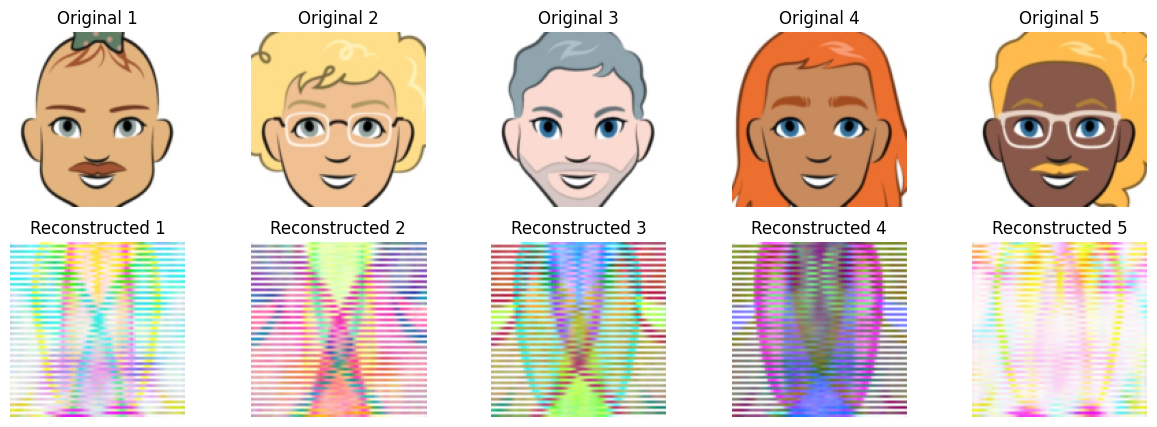

In [80]:
num_images = 5
model.eval()

with torch.no_grad():
    data, _ = next(iter(testLoader))
    data = data.to(DEVICE)
    _, _, _, encoded_data = model(data)
    reconstructed_images = model.decoder(encoded_data)

fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

for i in range(num_images):
    original_img = data[i].cpu().numpy().transpose(1, 2, 0)
    reconstructed_img = reconstructed_images[i].cpu().numpy().transpose(1, 2, 0)

    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f"Original {i + 1}")
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_img)
    axes[1, i].set_title(f"Reconstructed {i + 1}")
    axes[1, i].axis('off')

plt.show()

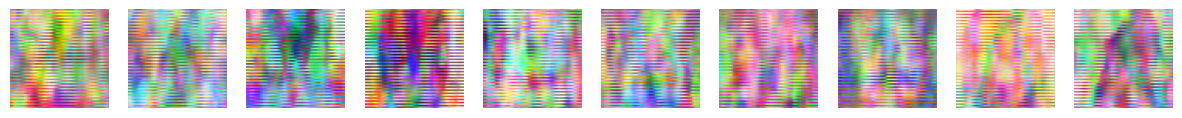

In [81]:
SEED = 33
torch.manual_seed(SEED)
np.random.seed(SEED)

model.eval()
num_samples = 10
with torch.no_grad():
    random_latent_vectors = torch.randn(num_samples, 200).to(DEVICE)
    generated_images = model.decoder(random_latent_vectors)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i in range(num_samples):
    img = generated_images[i].cpu().numpy().transpose(1, 2, 0)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.show()
